In [1]:
import pandas as pd 
import numpy as np
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (8, 4)

## Семинар №5: Решаем аналитические кейсы

In [3]:
url = 'https://raw.githubusercontent.com/hse-econ-data-science/andan_2023/main/sem05_pandas_adv/data/sales_data.csv'
df = pd.read_csv(url)

### 1. Смотрим на данные

In [10]:
df.shape

(187205, 7)

Пропуски

In [13]:
df.isnull().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
User ID             545
dtype: int64

In [15]:
df.dropna(inplace=True)

Формат колонок

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186660 entries, 0 to 186659
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186660 non-null  object
 1   Product           186660 non-null  object
 2   Quantity Ordered  186660 non-null  object
 3   Price Each        186660 non-null  object
 4   Order Date        186660 non-null  object
 5   Purchase Address  186660 non-null  object
 6   User ID           186660 non-null  object
dtypes: object(7)
memory usage: 11.4+ MB


In [19]:
df['Order ID'].astype('int')

ValueError: invalid literal for int() with base 10: 'Order ID'

In [27]:
df[~df['Order ID'].str.isdigit()]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
157,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
679,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
814,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
897,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
1071,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
...,...,...,...,...,...,...,...
184639,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
185261,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
186155,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID
186565,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID


In [28]:
df = df[df['Order ID'].str.isdigit()]

In [32]:
df['Order ID'] = df['Order ID'].astype('int')
df['Quantity Ordered'] = df['Quantity Ordered'].astype('int')
df['Price Each'] = df['Price Each'].astype('float')
df['User ID'] = df['User ID'].astype('float').astype('int')

In [36]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186659
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  int64         
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
 6   User ID           185950 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 11.3+ MB


Посмотреть на распределения

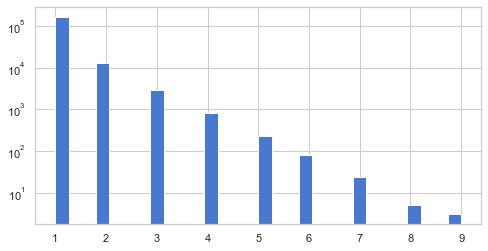

In [48]:
df['Quantity Ordered'].hist(bins=30, log=True);

In [50]:
df['Product'].value_counts()

USB-C Charging Cable          21903
Lightning Charging Cable      21658
AAA Batteries (4-pack)        20641
AA Batteries (4-pack)         20577
Wired Headphones              18882
Apple Airpods Headphones      15549
Bose SoundSport Headphones    13325
27in FHD Monitor               7507
iPhone                         6842
27in 4K Gaming Monitor         6230
34in Ultrawide Monitor         6181
Google Phone                   5525
Flatscreen TV                  4800
Macbook Pro Laptop             4724
ThinkPad Laptop                4128
20in Monitor                   4101
Vareebadd Phone                2065
LG Washing Machine              666
LG Dryer                        646
Name: Product, dtype: int64

## Кейс №1: Реклама и пиар

Предположим, что перед нами стоит задача привлечения новых пользователей и удержание существующих. Для этого мы собираемся, во-первых, устраивать различные промоакции в периоды падения активности, чтобы стимулировать пользователей покупать товары, а во-вторых, запускать крупные рекламные кампании, наоборот, в период высокой активности пользователей, чтобы пользователи покупали товары именно в нашем интернет-магазине.

**Как определить период, когда следует запускать разного рода акции?**

Идея №1: В какой месяц у нас больше всего заказов?

In [53]:
df['Month'] = df['Order Date'].dt.month

In [56]:
bymonths = df.groupby('Month')['Order ID'].count()

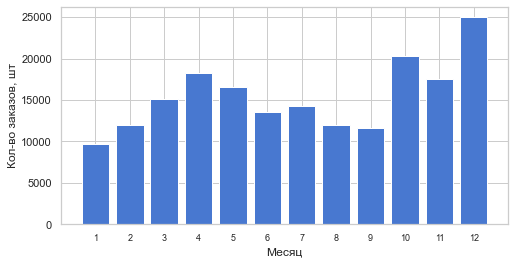

In [62]:
plt.bar(bymonths.index, bymonths.values)

plt.xticks(bymonths.index, size=9)
plt.ylabel('Кол-во заказов, шт', fontsize=12)
plt.xlabel('Месяц');

Идея №2: Посмотреть активность по часам

In [63]:
df['Hour'] = df['Order Date'].dt.hour

In [64]:
byhours = df.groupby('Hour')['Order ID'].count()

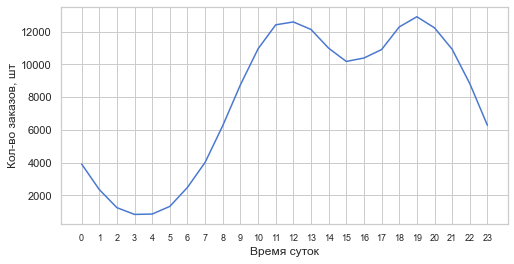

In [65]:
plt.plot(byhours.index, byhours.values)

plt.xticks(byhours.index, size=9)
plt.ylabel('Кол-во заказов, шт', fontsize=12)
plt.xlabel('Время суток');

## Кейс №2: Доверительный интервал для среднего чека

Предположим, что вы хотите понять, а сколько денег вы в среднем получаете с одного сделанного заказа. При этом вы хотите не только получить точечную оценку, посчитав среднее по выборке, но и построить для этого среднего доверительный интервал.

In [68]:
df['GMV'] = df['Quantity Ordered'] * df['Price Each']

In [70]:
byorders = df.groupby('Order ID')['GMV'].sum()

In [72]:
byorders.mean()

193.300918362983

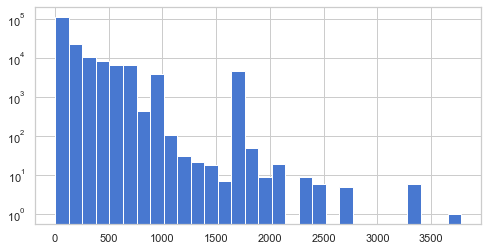

In [75]:
byorders.hist(bins=30, log=True);

In [78]:
mean_hat, std_hat, n = byorders.mean(), byorders.std(), byorders.shape[0]
alpha = 0.05

norm_gen = sts.norm(0, 1)
left_cr = norm_gen.ppf(alpha/2)
right_cr = norm_gen.ppf(1-alpha/2)

left = mean_hat + left_cr * std_hat/np.sqrt(n)
right = mean_hat + right_cr * std_hat/np.sqrt(n)

delta = right - left
print(f"Среднее по выборке: {mean_hat:.4}")
print(f"Доверительный интервал [{left:.4}, {right:.4}] ширины {delta:.4}")

Среднее по выборке: 193.3
Доверительный интервал [191.7, 194.9] ширины 3.167


Что тут не так?

In [85]:
byusers = df.groupby(['User ID', 'Order ID'])['GMV'].sum()
byorders_c = byusers.groupby('User ID').mean() # средний чек на одного пользователя

In [86]:
mean_hat, std_hat, n = byorders_c.mean(), byorders_c.std(), byorders_c.shape[0]
alpha = 0.05

norm_gen = sts.norm(0, 1)
left_cr = norm_gen.ppf(alpha/2)
right_cr = norm_gen.ppf(1-alpha/2)

left = mean_hat + left_cr * std_hat/np.sqrt(n)
right = mean_hat + right_cr * std_hat/np.sqrt(n)

delta = right - left
print(f"Среднее по выборке: {mean_hat:.4}")
print(f"Доверительный интервал [{left:.4}, {right:.4}] ширины {delta:.4}")

Среднее по выборке: 193.4
Доверительный интервал [191.6, 195.3] ширины 3.685


In [87]:
df

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,User ID,Month,Hour,GMV
0,165079,AA Batteries (4-pack),1,3.84,2019-03-24 19:17:00,"953 Johnson St, Boston, MA 02215",14152,3,19,3.84
1,289147,Macbook Pro Laptop,1,1700.00,2019-11-29 07:25:00,"826 13th St, Los Angeles, CA 90001",49793,11,7,1700.00
2,293940,AA Batteries (4-pack),1,3.84,2019-11-28 12:00:00,"543 Main St, San Francisco, CA 94016",4748,11,12,3.84
3,288851,Lightning Charging Cable,1,14.95,2019-11-02 18:32:00,"601 Maple St, Los Angeles, CA 90001",73924,11,18,14.95
4,239927,Apple Airpods Headphones,1,150.00,2019-08-09 20:35:00,"88 Maple St, Los Angeles, CA 90001",23344,8,20,150.00
...,...,...,...,...,...,...,...,...,...,...
186655,194862,Vareebadd Phone,1,400.00,2019-05-19 09:01:00,"466 Dogwood St, San Francisco, CA 94016",69908,5,9,400.00
186656,206915,Bose SoundSport Headphones,1,99.99,2019-05-07 09:16:00,"464 Johnson St, New York City, NY 10001",40697,5,9,99.99
186657,253450,USB-C Charging Cable,2,11.95,2019-09-13 21:04:00,"501 Chestnut St, New York City, NY 10001",28413,9,21,23.90
186658,193390,AAA Batteries (4-pack),2,2.99,2019-04-12 13:43:00,"722 Lake St, New York City, NY 10001",46472,4,13,5.98
